In [17]:
# %% imports
# libraries
import torch
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
import os
import numpy as np

# local imports
import MNIST_dataloader
# import autoencoder_template
from config_file import data_loc
from matplotlib import pyplot as plt
from MNIST_dataloader import create_dataloaders

# Week 1

### Exercise 1 - ISTA

##### (a)[3 pt]Create a Python function that implements ISTA for MNIST denoising. 
Make sure the function takes as inputs: step size μ, shrinkage parameter λ, number of
iteration K, and measurements (batch of MNIST images) y. It should output the
final batch of reconstructions xK.

hint: the images are normalized between -1 and 1, which means the background of the
images is not at zero. Think about how to still aply ISTA correctly.

In [6]:
########## Define Paramters
mu = 1e-4       # Step-size
shrinkage = 0   # 
K = 10          # Amount of itereations

In [7]:
### prepare the datasets
# get dataloader
batch_size = 64
train_loader, test_loader, val_loader = create_dataloaders(data_loc, batch_size)

In [9]:
# %% ISTA
def softthreshold(x,shrinkage):
    '''
    Implement soft threshold:
    F(x) = sign(x) * max(|x|)-lambda, 0_
    Arguments:
    ----------------------
    x: data-set (default: train_dataset)??
    shrinkage: float (default: --)
    '''
    p1 = torch.sign(x)
    p2 = torch.max(torch.abs(x)-shrinkage, torch.zeros_like(x))
    new = p1*p2
    # print(new)
    return new

def ISTA(mu,shrinkage,K,y):
    '''
    Iterative shrinkage and Thresholding Algorithm

    Arguments:
    --------------------
    mu:     float (default: 0.5)
        The stepsize

    shrinkage:  float (default: 0.5)
        The shrinking paramter
    
    K: int (default: 10)
        The number of unfolding iterations
    
    y: ??? (default: ???)
        The measurement image.

    Returns:
    --------------------
    x: ??? (default: ???)
        The denoised image    
    '''
    # initialize
    ##### Using flattened features
    # y2 = y.flatten()
    # x = torch.zeros_like(y2)
    # A = torch.eye(len(y2)) # length = WxH of image y

    # init params
    # mu = 0.8
    # lamda = 0.3
    # K = 40

    lamda = shrinkage
    # load in a noisy image
    # y = x_noisy_example[5,:,:,:]

    # flatten it
    y_flat = y.flatten() # values can be around (~-3,3)
    # normalize it 
    # linear rescale to range [0, 1]
    y_flat -= y_flat.min() # bring the lower range to 0
    y_flat /= y_flat.max() # bring the upper range to 1

    # linear rescale to range [-1, 1]
    # y_flat = 2*y_flat - 1

    # make an identity matrix
    A = torch.eye(len(y_flat))  
    x_in = torch.zeros_like(y_flat)

    x_k_0 = torch.matmul(y_flat,(A.T)) # --> soft-treshold ---> I-mu*A.T*A
    #x_k = [mu*A.T*y + [x_in*I - mu*A*A.T*x_in]]
    x_k = mu*x_k_0 + (x_in@A-mu*x_in@A.T@A)
    K = 10000
    err = 1
    while err > 1e-7:
        for i in range (K):
            x_k = mu*x_k_0 + (x_in@A-mu*x_in@A.T@A)
            x_k_soft = softthreshold(x_k,lamda)
            err = torch.nn.functional.mse_loss(x_k_soft,x_in).item()
            x_in = x_k_soft
            # print(err)
    
    z = x_in.reshape(y.shape)
    return z

In [10]:
train_loader, val_loader, test_loader = create_dataloaders(data_loc,batch_size)
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels
x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

# First 10 numbers
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]




In [11]:
# y = x_noisy_example[5,:,:,:]
# plt.imshow(y[0,:,:],cmap='gray')


In [220]:
# z = x_in.reshape(y.shape)
# plt.imshow(z[0,:,:],cmap='gray')
# print(y_flat+1)
# normalize
# torch.nn.functional.normalize(input, p=2.0, dim=1, eps=1e-12, out=None)
y = x_noisy_example[3,:,:,:]
print(torch.max(y))
torch.any(y < -1)
print(torch.min(x_noisy_example[:,:,:,:]).item())
x_noisy_train

tensor(1.9674)
-3.678187370300293


##### (b) [2 pt] Use your ISTA algorithm on 10 example images. 
Show them in a figure consisting of 10 collumns (1 per digit) and 3 rows. Row 1 should contain the noisy
measurement, row 2 the reconstruction, and row 3 the actual ground truth target.
You will have to play with the values for μ, λ, and K. Explain what you see.

In [12]:
train_loader, val_loader, test_loader = create_dataloaders(data_loc,batch_size)
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels
x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

# use these 10 examples as representations for all digits
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]

Text(0.5, 0.98, 'Denoising using ISTA')

<Figure size 2160x720 with 0 Axes>

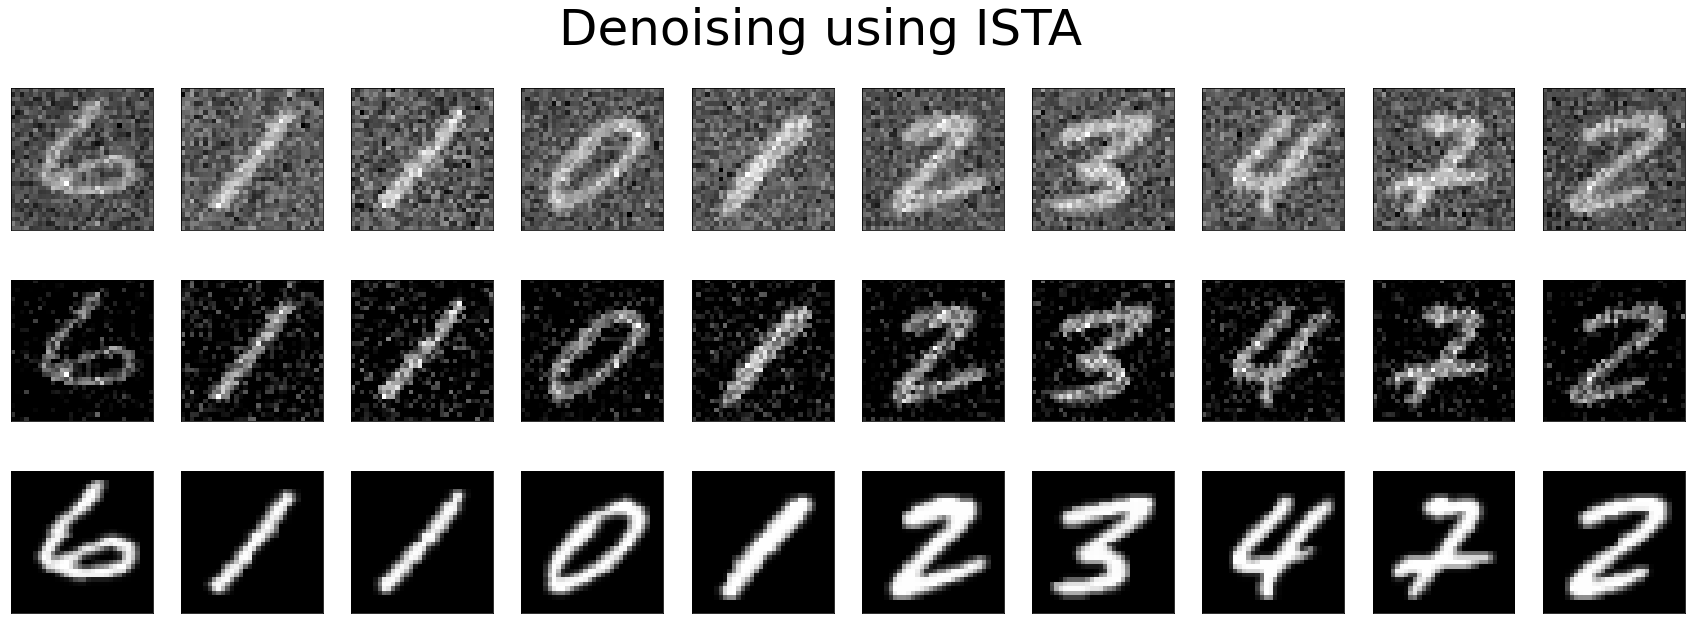

In [16]:
plt.figure(figsize=(30,10))
mu = 0.8
lamda = 0.3
K = 100

    # for i in range(10):
    #     z = ISTA(mu,lamda,K,x_noisy_example[i,:,:,:])
    #     plt.subplot(3,10,i+1)
    #     plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    #     plt.xticks([])
    #     plt.yticks([])

    #     plt.subplot(3,10,i+11)
    #     plt.imshow(z[0,:,:],cmap='gray')
    #     plt.xticks([])
    #     plt.yticks([])

    #     plt.subplot(3,10,i+21)
    #     plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    #     plt.xticks([])
    #     plt.yticks([])

# First 10 numbers
x_clean_example = test_loader.dataset.Clean_Images[0:10,:,:,:]
x_noisy_example = test_loader.dataset.Noisy_Images[0:10,:,:,:]
labels_example = test_loader.dataset.Labels[0:10]

# Plot
ax = plt.figure(figsize=(30,10))
for i in range(10):
    z = ISTA(mu,lamda,K,x_noisy_example[i,:,:,:])
    plt.subplot(3,10,i+1)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3,10,i+11)
    plt.imshow(z[0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

    plt.subplot(3,10,i+21)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
plt.suptitle("Denoising using ISTA", fontsize=50)


##### (c) [1 pt] To get a numerical estimate for the performance of ISTA, run it on the entire test set and report the resulting mean squared error (mse).

# Week 2

### Exercise 3 - MRI helper functions

#### (a) [2pt]Create a Python function that, given an MRI image, calculates the K-space.
Make sure to only use PyTorch functions and that the function can work on multiple
images in parallel. Visualize a ground truth image with its accompanying full k-space
measurement.
hint: make sure that the DC (i.e., 0 Hz component) is at the center of the image.
Moreover, plotting the log of the absolute value of the k-space provides better contrast.

#### (b) [1pt]Create a Python function that, given a full k-space and measurement matrix, calculates the partial k-space.

#### (c) [2pt]Create a Python function that, given a partial k-space, calculates the accelerated measurement image. Visualize a partial k-space with its accompanying accelerated MRI.